# Створення базових моделей

**Частина 1**

Необхідно визначити в коді натупне:

1. Базову модель для навчання (виберіть який тип моделі хочете натренувати CNN, MLP тощо).
2. Початкову кількість шарів та їх параметри.
3. Функції для тренування та валідації, візуалізації результатів, фінкцію втрат та метрику перевірки результатів.
4. Натренуйте модель і перевірте результат. Яке значення функції втрат, яка метрика вашої моделі після навчання? Візуалізуйте графіки навчання. Скільки часу потрібно було на тренування?

**Частина 2**

1. Опишіть гіперпараметри моделі: кількість шарів/кількість нейронів в шарах, різні їх комбінації.
2. Підберіть та перевірте найкращі гіперпараметри вашої моделі за яких метрика під час валідації буде найвищою. Скільки часу потрібно було на підбір гіперпараметрів моделі?
3. Продемонструйте на яких класах та зображеннях найчастіше помиляється найкраща модель.
4. Візуалізувати графіки залежностей між гіперпараметрами найкращої моделі і змінами значень її метрики.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import os
import torch.optim as optim
import optuna
from optuna.trial import TrialState
import time
import cv2
import numpy as np

C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
datasets_path = './datasets'
train_dataset = FashionMNIST(datasets_path, 
                               train=True, 
                               download=True, 
                               transform=transform)

validation_dataset = FashionMNIST(datasets_path, 
                                    train=False, 
                                    transform=transform)

In [5]:
batch_size = 32

In [6]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

In [7]:
validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

In [8]:
plt_size = 2

In [9]:
plt_images = 8

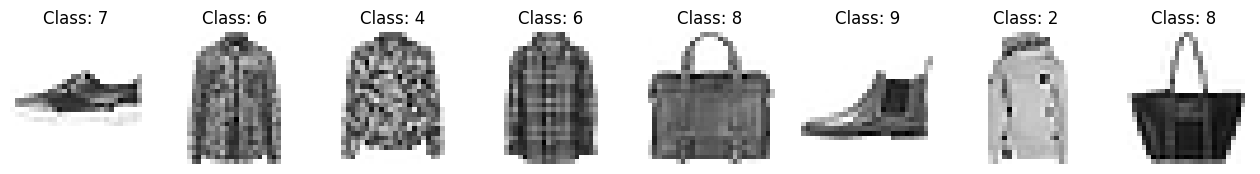

In [10]:
for (X_train, y_train) in train_loader:
    plt.figure(figsize=(plt_images * plt_size, plt_size))

    for i in range(plt_images):
        plt.subplot(1, plt_images, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
        plt.title(f'Class: {y_train[i].item()}')

    break

In [11]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [55]:
def train(model, epoch, optimizer, criterion, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [15]:
def validate(model, loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [16]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model, epoch)
    validate(model, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300303
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.255402
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.857644
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.137890
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.751139
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.687486
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.823505
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.669815
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.695687
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.410327

Validation set: Average loss: 0.6701, Accuracy: 7616/10000 (76%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.690491
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.537575
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.396564
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.758116
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.708451
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.320964
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.394439
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.408626
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.58

Text(0.5, 1.0, 'validation loss')

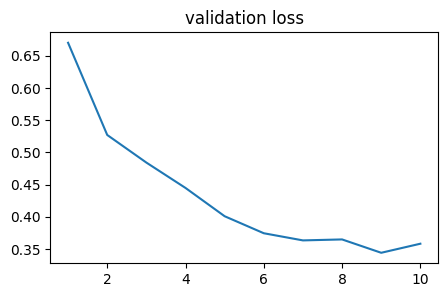

In [17]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

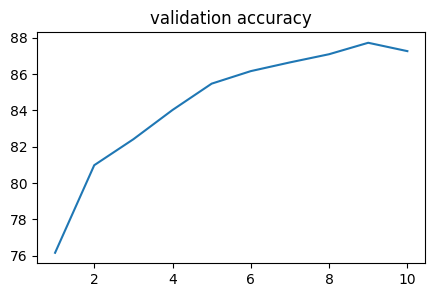

In [18]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [19]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

Змінимо к-сть шарів та оптимайзер
Result:
Validation set: Average loss: 0.3604, Accuracy: 8691/10000 (87%)

CPU times: total: 23min 12s
Wall time: 4min 23s

In [33]:
model2 = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[640, 512, 386, 256, 128, 64, 32]).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [34]:
model2

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=386, bias=True)
    (5): ReLU()
    (6): Linear(in_features=386, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [35]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model2, epoch)
    validate(model2, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298440
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.019843
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.831015
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.700106
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.527160
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.580500
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.698220
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.570234
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.447335
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.941655

Validation set: Average loss: 0.4787, Accuracy: 8278/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.287633
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.280010
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.585774
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.587666
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.353572
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.356866
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.396636
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.190177
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.34

Text(0.5, 1.0, 'validation loss')

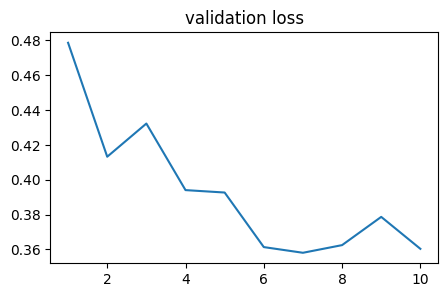

In [36]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

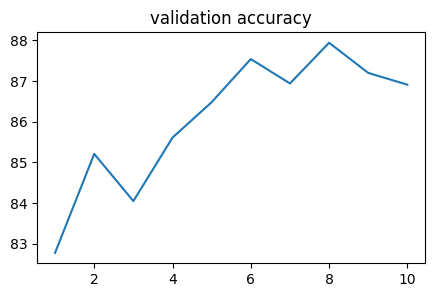

In [37]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

In [38]:
model3 = BaseNetwork(act_fn=nn.ReLU()).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [39]:
model3

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [43]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(model3, epoch)
    validate(model3, lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.108949
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.406530
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.189220
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.121577
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.170178
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.077162
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.158719
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.237712
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.175362
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.184355

Validation set: Average loss: 0.3750, Accuracy: 8874/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.438676
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.156818
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.098112
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.098564
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.410684
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.070238
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.108499
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.237850
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.19

Text(0.5, 1.0, 'validation loss')

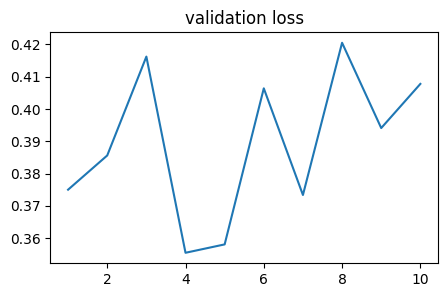

In [44]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

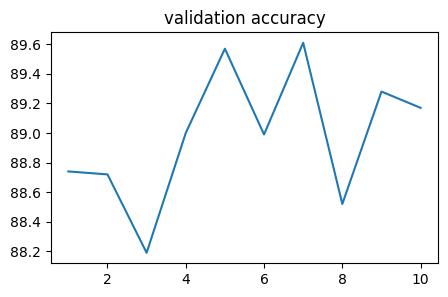

In [45]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

протестовано 3 моделі
1)SGC +  784, 512, 256, 256, 128, 10  lr=0.01
Validation set: Average loss: 0.3585, Accuracy: 8726/10000 (87%)

CPU times: total: 11min 58s
Wall time: 2min 
19s
2)ADAMари 784, 640, 512, 386, 256, 128, 64, 32, 10   lr=0.001
Validation set: Average loss: 0.3604, Accuracy: 8691/10000 (87%)

CPU times: total: 23min 12s
Wall time: 4m
in 23s
3)A+ шари 784, 512, 256, 256, 128, 10  lr=0.01
Validation set: Average loss: 0.4078, Accuracy: 8917/10000 (89%)

CPU times: total: 16min 14s
Wall t
ime: 3min

Виконаю підбір гіперпараметрів
https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36

In [72]:
def define_model(trial):
    # We optimize the number of layers, hidden untis and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 2, 5)
    hidden_sizes = []

    for i in range(n_layers):
        layer_size = trial.suggest_int("n_units_l{}".format(i), 10, 768)
        hidden_sizes.append(layer_size)

    return BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=hidden_sizes)

In [73]:
def validate_model(model, criterion):
    model.eval()
    val_loss, correct = 0, 0

    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))
    
    return (val_loss, accuracy)

In [74]:
def objective(trial):
    # Generate the model.
    model = define_model(trial).to(device)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(1, epochs + 1):
        train(model, epoch, optimizer, criterion)
        loss, acc = validate_model(model, criterion)

        trial.report(acc, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    return acc

In [75]:
study = optuna.create_study(direction="maximize")


[I 2023-11-12 20:25:50,854] A new study created in memory with name: no-name-1ac2af77-0111-4812-ae78-5b18f1237bff


In [76]:
study

In [77]:
study.optimize(objective, n_trials=20)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306742
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.440183
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.319124
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.277745
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.244872
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.281338
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.305637
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.330748
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.335240
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.322219

Validation set: Average loss: 2.3101, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.342033
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.300109
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.354554
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.332489
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.316336
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.340196
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.321688
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.308439
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.31

[I 2023-11-12 20:27:59,913] Trial 0 finished with value: 10.0 and parameters: {'n_layers': 2, 'n_units_l0': 180, 'n_units_l1': 347, 'optimizer': 'RMSprop', 'lr': 0.050359184656631376}. Best is trial 0 with value: 10.0.



Validation set: Average loss: 2.3082, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298350
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.338112
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.918015
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.874934
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.990399
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.843740
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.540270
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.702612
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.652965
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.806717

Validation set: Average loss: 0.6528, Accuracy: 7628/10000 (76%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.547041
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.734412
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.570598
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.619822
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.521962
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.856621
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.575458
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:31:04,688] Trial 1 finished with value: 85.0999984741211 and parameters: {'n_layers': 3, 'n_units_l0': 568, 'n_units_l1': 684, 'n_units_l2': 188, 'optimizer': 'RMSprop', 'lr': 1.7292504789911558e-05}. Best is trial 1 with value: 85.0999984741211.



Validation set: Average loss: 0.4157, Accuracy: 8510/10000 (85%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300807
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.176236
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.921694
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.590067
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.107868
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.341379
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.283565
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.283131
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.110041
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.295099

Validation set: Average loss: 2.3998, Accuracy: 1099/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.270721
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.349250
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.306383
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.358307
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.319097
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.323294
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.300047
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:34:20,651] Trial 2 finished with value: 10.0 and parameters: {'n_layers': 2, 'n_units_l0': 496, 'n_units_l1': 589, 'optimizer': 'RMSprop', 'lr': 0.08738224215013767}. Best is trial 1 with value: 85.0999984741211.



Validation set: Average loss: 2.3540, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308399
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.284826
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.304549
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.310875
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.291354
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.305541
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.289294
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.300713
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.280667
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.309213

Validation set: Average loss: 2.3043, Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.296882
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.328351
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.300530
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.316210
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.309203
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.301189
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.314469
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:38:55,100] Trial 3 finished with value: 10.0 and parameters: {'n_layers': 5, 'n_units_l0': 720, 'n_units_l1': 405, 'n_units_l2': 475, 'n_units_l3': 582, 'n_units_l4': 41, 'optimizer': 'Adam', 'lr': 0.016557408987426067}. Best is trial 1 with value: 85.0999984741211.



Validation set: Average loss: 2.3034, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304801
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.290473
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.236136
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.775760
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.235371
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.098358
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.838335
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.641196
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.730558
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.702405

Validation set: Average loss: 0.7726, Accuracy: 7098/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.686118
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.675775
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.639117
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.626689
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.723160
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.521987
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.723527
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:41:11,484] Trial 4 finished with value: 87.2300033569336 and parameters: {'n_layers': 4, 'n_units_l0': 519, 'n_units_l1': 38, 'n_units_l2': 69, 'n_units_l3': 243, 'optimizer': 'SGD', 'lr': 0.014032423980150822}. Best is trial 4 with value: 87.2300033569336.



Validation set: Average loss: 0.3599, Accuracy: 8723/10000 (87%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.280220
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.294984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.282130
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.300282
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.283270
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.286087
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.299461
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.291713
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.282025
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.290752

Validation set: Average loss: 2.2908, Accuracy: 1682/10000 (17%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.297048
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.297267
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.298052
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.301518
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.287110
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.295074
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.298494
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:42:56,209] Trial 5 finished with value: 32.04999923706055 and parameters: {'n_layers': 2, 'n_units_l0': 61, 'n_units_l1': 463, 'optimizer': 'SGD', 'lr': 1.666185269178751e-05}. Best is trial 4 with value: 87.2300033569336.



Validation set: Average loss: 2.2548, Accuracy: 3205/10000 (32%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296678
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.513528
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.141961
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.450186
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.501168
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.583723
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.212188
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.634517
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.147287
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.448667

Validation set: Average loss: 0.4261, Accuracy: 8452/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.261313
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.533750
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.157842
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.336397
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.406909
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.555995
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.617963
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:45:18,729] Trial 6 finished with value: 88.16999816894531 and parameters: {'n_layers': 2, 'n_units_l0': 279, 'n_units_l1': 767, 'optimizer': 'Adam', 'lr': 0.001844782273175181}. Best is trial 6 with value: 88.16999816894531.



Validation set: Average loss: 0.3490, Accuracy: 8817/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.283809
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.559150
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.136266
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.978239
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.296214
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.748761
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.793487
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.025782
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.681722

Validation set: Average loss: 0.6896, Accuracy: 7328/10000 (73%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.280193
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.630937
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.524212
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.323843
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.442933
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.601490
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.783922
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:48:37,470] Trial 7 finished with value: 87.52999877929688 and parameters: {'n_layers': 5, 'n_units_l0': 453, 'n_units_l1': 723, 'n_units_l2': 438, 'n_units_l3': 758, 'n_units_l4': 110, 'optimizer': 'SGD', 'lr': 0.03742342767330387}. Best is trial 6 with value: 88.16999816894531.



Validation set: Average loss: 0.3451, Accuracy: 8753/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295980
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.138248
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.917198
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.045233
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.606231
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.908058
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.542538
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.708016
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.456372
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.491448

Validation set: Average loss: 0.5952, Accuracy: 7865/10000 (79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.507912
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.493303
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.407229
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.485779
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.384289
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.463010
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.890595
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:50:29,656] Trial 8 finished with value: 85.80000305175781 and parameters: {'n_layers': 2, 'n_units_l0': 112, 'n_units_l1': 606, 'optimizer': 'RMSprop', 'lr': 4.280886733052512e-05}. Best is trial 6 with value: 88.16999816894531.



Validation set: Average loss: 0.4029, Accuracy: 8580/10000 (86%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309511
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.005220
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.381248
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.251263
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.208292
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.721884
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.924039
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.618498
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.917330
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.825945

Validation set: Average loss: 0.6943, Accuracy: 7514/10000 (75%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.549614
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.762261
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.443535
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.778147
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.602669
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.439902
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.531678
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:51:26,145] Trial 9 pruned. 



Validation set: Average loss: 0.5289, Accuracy: 8097/10000 (81%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305662
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.519249
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.538677
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.468763
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.373886
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.464774
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.262944
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.589704
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.169806
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.316413

Validation set: Average loss: 0.4156, Accuracy: 8481/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.603111
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.244472
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.141725
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.866387
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.512915
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.338827
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.254457
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:53:44,668] Trial 10 finished with value: 86.66999816894531 and parameters: {'n_layers': 3, 'n_units_l0': 281, 'n_units_l1': 134, 'n_units_l2': 710, 'optimizer': 'Adam', 'lr': 0.0013647411670916283}. Best is trial 6 with value: 88.16999816894531.



Validation set: Average loss: 0.3942, Accuracy: 8667/10000 (87%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302363
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.306700
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.300040
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.304643
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.301121
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.290350
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.301702
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.300155
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.304573
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.298102


[I 2023-11-12 20:54:04,817] Trial 11 pruned. 



Validation set: Average loss: 2.2970, Accuracy: 1907/10000 (19%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307349
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.296733
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.304057
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.301748
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.305343
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.300856
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.302180
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.306604
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.299846
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.293355


[I 2023-11-12 20:54:24,553] Trial 12 pruned. 



Validation set: Average loss: 2.2996, Accuracy: 1384/10000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308262
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.487736
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.713074
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.489465
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.485279
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.537617
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.289391
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.350955
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.249398
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.790840

Validation set: Average loss: 0.4975, Accuracy: 8264/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.304329
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.409368
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.494469
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.565037
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.570270
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.903081
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.131068
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:57:00,953] Trial 13 finished with value: 85.91999816894531 and parameters: {'n_layers': 3, 'n_units_l0': 252, 'n_units_l1': 549, 'n_units_l2': 340, 'optimizer': 'Adam', 'lr': 0.004534664343874078}. Best is trial 6 with value: 88.16999816894531.



Validation set: Average loss: 0.4317, Accuracy: 8592/10000 (86%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306602
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300171
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.303369
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.299762
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.297645
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.300770
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.302642
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.303198
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.302002
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.299893


[I 2023-11-12 20:57:26,697] Trial 14 pruned. 



Validation set: Average loss: 2.3021, Accuracy: 1001/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309727
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.832316
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.528260
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.483826
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.772946
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.569240
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.486133
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.363996
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.622133
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.028186

Validation set: Average loss: 0.5169, Accuracy: 8137/10000 (81%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.495309
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.373656
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.367795
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.402206
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.504776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.416648
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.381077
Train Epoch: 2 [44800/60000 

[I 2023-11-12 20:59:07,663] Trial 15 pruned. 



Validation set: Average loss: 0.4409, Accuracy: 8459/10000 (85%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304527
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.064158
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.986663
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.753322
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.937904
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.859830
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.789865
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.806225
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.705524
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.747158


[I 2023-11-12 20:59:23,484] Trial 16 pruned. 



Validation set: Average loss: 0.7453, Accuracy: 7084/10000 (71%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296171
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.130988
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.996872
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.861399
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.751031
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.664330
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.694300
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.372809
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.436890
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.602009

Validation set: Average loss: 0.4876, Accuracy: 8179/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.600258
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.584314
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.539687
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.259070
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.599878
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.381365
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.327298
Train Epoch: 2 [44800/60000 

[I 2023-11-12 21:02:38,746] Trial 17 finished with value: 88.04000091552734 and parameters: {'n_layers': 5, 'n_units_l0': 657, 'n_units_l1': 661, 'n_units_l2': 393, 'n_units_l3': 309, 'n_units_l4': 441, 'optimizer': 'SGD', 'lr': 0.09841582944932813}. Best is trial 6 with value: 88.16999816894531.



Validation set: Average loss: 0.3322, Accuracy: 8804/10000 (88%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.286910
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.940511
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.559986
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.751698
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.475120
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.831101
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.294662
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.315004
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.290961
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.342974


[I 2023-11-12 21:03:01,595] Trial 18 pruned. 



Validation set: Average loss: 2.3152, Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302587
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.293179
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.259879
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.110481
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.566457
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.061504
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.932190
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.123990
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.752549
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.722460


[I 2023-11-12 21:03:17,077] Trial 19 pruned. 



Validation set: Average loss: 0.8206, Accuracy: 7062/10000 (71%)



In [78]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  8
  Number of complete trials:  12
Best trial:
  Value:  88.16999816894531
  Params: 
    n_layers: 2
    n_units_l0: 279
    n_units_l1: 767
    optimizer: Adam
    lr: 0.001844782273175181


In [100]:
best_model = define_model(best_trial).to(device)

best_optimizer = getattr(torch.optim, trial.params["optimizer"])(
    best_model.parameters(),
    lr=trial.params["lr"]
)
best_criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    train(best_model, epoch, best_optimizer, best_criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310578
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.609773
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.568563
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.610100
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.496683
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.228269
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.392975
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.710213
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.286727
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.650341
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.408904
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.336801
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.214691
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.220558
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.332017
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.226940
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.270802
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.370857
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.358008
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.529879
Train Epoch:

Але всеодно найкращою є model3

NameError: name 'avg_losses' is not defined

<Figure size 2000x500 with 0 Axes>